In [120]:
import pandas as pd
import re
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import pgeocode

# Einlesen der Daten


In [121]:
df = pd.read_csv("../data/immo_data_202208_v2.csv", low_memory=False)
df.drop(["Unnamed: 0.1","Unnamed: 0"], axis=1,inplace=True) #Zwei Spalten für Index entfernen
df.head()

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,https://www.immoscout24.ch//en/d/terrace-house...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,"5022 Rombach, AG","2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...","detail_responsive#description_title2,5 Zimmerw...",https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN
3,Biberstein,154 m²,370 m²,257 m²,On request,"Buhaldenstrasse 8A5023 Biberstein, AG","4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",DescriptionDieses äusserst grosszügige Minergi...,https://www.immoscout24.ch//en/d/detached-hous...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
4,Küttigen,142 m²,NaN,NaN,On request,"5022 Rombach, AG","4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",DescriptionAus ehemals zwei Wohnungen wurde ei...,https://www.immoscout24.ch//en/d/flat-buy-romb...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Columns: 132 entries, Municipality to space_cleaned
dtypes: float64(63), int64(2), object(67)
memory usage: 22.6+ MB


Das Dataset besteht aus 22481 Zeilen und 132 Spalten. Die meisten Spalten sind vom Typ object und float, diese werden sich noch angepasst.

## Duplikate zählen

In [123]:
print(df.duplicated().sum())

0


Datensatz scheint keine Duplikate zu haben.

## Fehlende Daten zählen

In [124]:
print(df.isna().sum().sum())

1179856


Das Dataset hat sehr viele fehlende Werte. <br>
Wir untersuchen nun die Spalten mit den meisten fehlenden Werten.

In [125]:
df.isna().sum().sort_values(ascending=False).head(10)

Minimum floor space:      22479
Superficie utile          22475
Gross return              22475
Piano                     22471
Superficie del terreno    22470
Surface utile             22467
Gross yield:              22467
Étage                     22457
Superficie abitabile      22454
Comune                    22454
dtype: int64

Die Top 10 Spalten mit den meisten fehlenden Werten sind, zeigt deutlich das fasst die ganze Spalte leer ist. <br>
Da sich Spalten gegenseitig abdecken werden müssen wir diese genauer untersuchen. <br>  
Wir untersuchen nun wie viele Spalten keine fehlende Werte haben.

In [126]:
print((df.isna().sum() == 0).sum())

48


Wir haben 48 Spalten von 132 Spalten die keine na-Werte haben. <br>

**Zusammengefasst:** <br>
Es gibt sehr viele fehlende Werte. Wenn man die Spalten untersucht sieht man, dass es Spalten gibt wie "Minimum floor space:" welche 22479 fehlende Werte von 22481 hat. Es gibt aber auch 48 von 132 Spalten die keine fehlende Werte enthalten. <br>
Was mit den Spalten passiert, die so viele fehlende Werte haben wird in einem nächsten Schritt entschieden, da diese mit anderen Spalten kombiniert werden kann.


# Untersuchen der Preissplaten

In [127]:
price_cols = df[["price","price_cleaned","price_s"]] #Filtern der Preis Spalten
price_cols.head()

,price,price_cleaned,price_s
0,"CHF 1,150,000.—",1150000.0,NaN
1,"CHF 1,420,000.—",1420000.0,NaN
2,"CHF 720,000.—",720000.0,NaN
3,"CHF 1,430,000.—",1430000.0,NaN
4,"CHF 995,000.—",995000.0,NaN


Untersuchen der fehlenden Werte in den Preis Spalten.

In [128]:
price_cols.isna().sum()

price                0
price_cleaned     1015
price_s          13355
dtype: int64

Price haben keine fehlende Werte, price_cleaned hat ungefähr 1000 fehlende Werte und price_s hat 13355 fehlende Werte. <br>
Da price_cleaned unsere Zielspalte ist, untersuchen wir die fehlenden Werte genauer.

In [129]:
price_cols[price_cols["price_cleaned"].isna()].head(10)

,price,price_cleaned,price_s
21,Price on request,NaN,NaN
27,Price on request,NaN,NaN
28,Price on request,NaN,NaN
29,Price on request,NaN,NaN
33,Price on request,NaN,NaN
43,Price on request,NaN,NaN
49,Price on request,NaN,NaN
56,Price on request,NaN,NaN
100,Price on request,NaN,NaN
105,Price on request,NaN,NaN


Auffällig ist, dass price bei den nan-Werte der price_cleaned Spalte immer ein Price on request eingetragen ist. <br>
Wir ersetzten nun die Price on request Werte mit nan.

In [130]:
price_cols = price_cols.replace("Price on request", np.nan)
price_cols.isna().sum()

price             1015
price_cleaned     1015
price_s          13355
dtype: int64

Mit dieser anpassung scheinen price und price_cleaned identisch zu sein. <br>
Was uns noch interessiert ist ob es mehrere Währungen gibt.

In [131]:
filtered_df = df[~df['price'].str.contains('CHF')]
filtered_df["price"].value_counts()

price
Price on request    1015
EUR 495,000.—          2
EUR 635,000.—          1
EUR 780,000.—          1
EUR 190,000.—          1
EUR 650,000.—          1
EUR 1,639,000.—        1
EUR1,130,000.–         1
EUR1,200,000.–         1
EUR1,340,000.–         1
EUR1,645,000.–         1
EUR1,880,000.–         1
EUR2,130,000.–         1
EUR5,500,000.–         1
EUR10,000,000.–        1
EUR200,000.–           1
EUR1,180,000.–         1
Name: count, dtype: int64

Wir haben nun entdeckt das wir auch Preise in Euro haben. <br>
Wir untersuchen nun ob die umrechnung stimmt.

In [132]:
price_cols[price_cols["price"]=="EUR 495,000.—"]

,price,price_cleaned,price_s
7682,"EUR 495,000.—",495000.0,NaN
7774,"EUR 495,000.—",495000.0,NaN


Die Umrechnung scheint 1zu1 übernommen worden zu sein. <br>
Da der Datensatz 2022 erstellt wurde und der Wechselkurs zwischen 1 und 1.05 lag vernachlässigen wir die Umrechnung. Auch das es nur 20 Werte hat, in Euro untermauert das Armgument es zu belassen. <br>
Nun müssen wir herausfinden was der Sinn von price_s ist.

In [133]:
price_cols[~price_cols["price_s"].isna()].tail()

,price,price_cleaned,price_s
22476,"CHF475,000.–",475000.0,"CHF 475,000.–"
22477,"CHF1,490,000.–",1490000.0,"CHF 2,194,770.–"
22478,"CHF1,450,000.–",1450000.0,"CHF 2,135,850.–"
22479,"CHF1,290,000.–",1290000.0,"CHF 1,290,000.–"
22480,"CHF780,000.–",780000.0,"CHF 1,148,940.–"


Schauen wir uns die letzten 5 Werte an, sehen wir das price_s und price_cleaned sich unterscheiden können. <br>
Wir untersuchen nun ein Beispiel.

In [134]:
df[df["price_s"] == "CHF 2,194,770.–"]

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
22477,Wil,NaN,NaN,NaN,NaN,"Fürstenlandstrasse 69, 9500 Wil",NaN,"Description\n""J'ADORE - Exklusives Wohnen in W...",https://www.homegate.ch/buy/3001826476,NaN,...,Balcony / Terrace\tWashing machine\tView\tWhee...,"Description\n""J'ADORE - Exklusives Wohnen in W...",NaN,3.0,NaN,9500.0,NaN,NaN,NaN,180.0


Da wir kein Indiz gefunden haben brauchte es Rücksprache mit unserem Dozent.
Die Spalte price_s ist eine Spalte die angezeigt wird bevor man auf die Detailseite klickt. <br>
Da wir keinen Nutzen sehen, und dem Model nicht eine Spalte geben möchten die manchaml den Preis enthält werden wir diese Spalte entfernen.

**Zusammengefasst:** <br>
price_cleaned ist die verarbeitete Spalte von price, somit ist nur price_cleaned benötigt. price_s ist der Anzeige Preis und hat keinen Nutzen für uns weshalb sie entfernt wird.

# Untersuchen der Gemeinde Spalten

Um die Features der Gemeinde zu analysieren filtern wir nach den dazugehörigen Features.

In [135]:
col_gemeinde = df[["Municipality","location","detail_responsive#municipality", "Gemeinde", "Commune","Comune", "Municipality_merged", "location_parsed", "address","lat", "lon", "Latitude", "Locality", "Longitude", "Zip","plz_parsed","address_s","plz"]]

In [136]:
col_gemeinde.head()

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Comune,Municipality_merged,location_parsed,address,lat,lon,Latitude,Locality,Longitude,Zip,plz_parsed,address_s,plz
0,Biberstein,"5023 Biberstein, AG",NaN,NaN,NaN,NaN,Biberstein,Strasse: plz:5023 Stadt: Biberstein Kanton: AG,"5023 Biberstein, AG",47.417100,8.085600,47.415927,Biberstein,8.085840,5023,5023.0,NaN,5023.0
1,Biberstein,"Buhldenstrasse 8d5023 Biberstein, AG",NaN,NaN,NaN,NaN,Biberstein,Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Buhldenstrasse 8d, 5023 Biberstein, AG",47.419500,8.082700,47.415927,Biberstein,8.085840,5023,5023.0,NaN,5023.0
2,NaN,"5022 Rombach, AG",Küttigen,NaN,NaN,NaN,NaN,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",47.403300,8.033000,47.397416,Aarau,8.043150,5000,5022.0,NaN,5022.0
3,Biberstein,"Buhaldenstrasse 8A5023 Biberstein, AG",NaN,NaN,NaN,NaN,Biberstein,Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...,"Buhaldenstrasse 8A, 5023 Biberstein, AG",47.415643,8.085423,47.415927,Biberstein,8.085840,5023,5023.0,NaN,5023.0
4,Küttigen,"5022 Rombach, AG",NaN,NaN,NaN,NaN,Küttigen,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",47.403824,8.048288,47.404870,Rombach,8.052781,5022,5022.0,NaN,5022.0


Wir suchen nun nach fehlende Werte in den Daten.

In [137]:
col_gemeinde.isna().sum()

Municipality                        931
location                              0
detail_responsive#municipality    22031
Gemeinde                          22323
Commune                           22415
Comune                            22454
Municipality_merged                9806
location_parsed                      17
address                            9126
lat                                  17
lon                                  17
Latitude                              0
Locality                              0
Longitude                             0
Zip                                   0
plz_parsed                           17
address_s                         13355
plz                                  17
dtype: int64

Wir möchten zuerst wissen, wie sich die Spalten bei denen sich es um den Gemeindename handelt. <br>
Auffällig ist, dass Municipality_merged mehr fehlende Wert hat als Municipality dies untersuchen wir.

In [138]:
col_gemeinde[(col_gemeinde["Municipality_merged"].isna()) & ~(col_gemeinde["Municipality"].isna())]

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Comune,Municipality_merged,location_parsed,address,lat,lon,Latitude,Locality,Longitude,Zip,plz_parsed,address_s,plz
13355,Lausanne,1000 Lausanne 26,NaN,NaN,NaN,NaN,NaN,Strasse: plz:1000 Stadt: Lausanne,NaN,46.521827,6.632702,46.520300,Lausanne,6.631849,1003,1000.0,1000 Lausanne 26,1000.0
13356,Lausanne,1004 Lausanne,NaN,NaN,NaN,NaN,NaN,Strasse: plz:1004 Stadt: Lausanne,NaN,46.521827,6.632702,46.520300,Lausanne,6.631849,1003,1004.0,1004 Lausanne,1004.0
13357,Lausanne,1004 Lausanne,NaN,NaN,NaN,NaN,NaN,Strasse: plz:1004 Stadt: Lausanne,NaN,46.521827,6.632702,46.520300,Lausanne,6.631849,1003,1004.0,1004 Lausanne,1004.0
13358,Lausanne,1018 Lausanne,NaN,NaN,NaN,NaN,NaN,Strasse: plz:1018 Stadt: Lausanne,NaN,46.521827,6.632702,46.520300,Lausanne,6.631849,1003,1018.0,1018 Lausanne,1018.0
13359,Lausanne,1018 Lausanne,NaN,NaN,NaN,NaN,NaN,Strasse: plz:1018 Stadt: Lausanne,NaN,46.521827,6.632702,46.520300,Lausanne,6.631849,1003,1018.0,1018 Lausanne,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,Buchs SG,"Altendorferstrasse 53, 9470 Buchs SG",NaN,NaN,NaN,NaN,NaN,"Strasse: Altendorferstrasse 53 , plz:9470 Sta...",NaN,47.158318,9.468165,47.158311,Buchs SG,9.468139,9470,9470.0,"Altendorferstrasse 53, 9470 Buchs SG",9470.0
22477,Wil,"Fürstenlandstrasse 69, 9500 Wil",NaN,NaN,NaN,NaN,NaN,"Strasse: Fürstenlandstrasse 69 , plz:9500 Sta...",NaN,47.467488,9.052574,47.467888,Wil SG,9.052650,9500,9500.0,"Fürstenlandstrasse 69, 9500 Wil",9500.0
22478,Wil SG,9500 Wil SG,NaN,NaN,NaN,NaN,NaN,Strasse: plz:9500 Stadt: Wil SG,NaN,47.465266,9.041548,47.463605,Wil SG,9.038485,9500,9500.0,9500 Wil SG,9500.0
22479,Matzingen,"Haldenstrasse 30, 9548 Matzingen",NaN,NaN,NaN,NaN,NaN,"Strasse: Haldenstrasse 30 , plz:9548 Stadt: ...",NaN,47.526504,8.927411,47.526024,Matzingen,8.926627,9548,9548.0,"Haldenstrasse 30, 9548 Matzingen",9548.0


Es gibt ~9100 Werte die Municipality hat die in Municipality_merged fehlen. Die ersten Werte scheinen vorallem aus der Umgebung von Lausanne zu liegen. Wir probieren diese Werte zu ergänzen

In [139]:
col_gemeinde.loc[:, "Municipality_merged"] = col_gemeinde["Municipality_merged"].fillna(col_gemeinde["Municipality"])
col_gemeinde.isna().sum()

Municipality                        931
location                              0
detail_responsive#municipality    22031
Gemeinde                          22323
Commune                           22415
Comune                            22454
Municipality_merged                 680
location_parsed                      17
address                            9126
lat                                  17
lon                                  17
Latitude                              0
Locality                              0
Longitude                             0
Zip                                   0
plz_parsed                           17
address_s                         13355
plz                                  17
dtype: int64

Mit der Imputation fehlen nur noch 680. <br>
Wir untersuchen diese noch einmal.

In [140]:
col_gemeinde[col_gemeinde["Municipality_merged"].isna()]

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Comune,Municipality_merged,location_parsed,address,lat,lon,Latitude,Locality,Longitude,Zip,plz_parsed,address_s,plz
2,NaN,"5022 Rombach, AG",Küttigen,NaN,NaN,NaN,NaN,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",47.403300,8.033000,47.397416,Aarau,8.043150,5000,5022.0,NaN,5022.0
28,NaN,"5042 Hirschthal, AG",Hirschthal,NaN,NaN,NaN,NaN,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,"5042 Hirschthal, AG",47.319992,8.054341,47.322260,Hirschthal,8.057802,5042,5042.0,NaN,5042.0
34,NaN,"5042 Hirschthal, AG",Hirschthal,NaN,NaN,NaN,NaN,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,"5042 Hirschthal, AG",47.319992,8.054341,47.322260,Hirschthal,8.057802,5042,5042.0,NaN,5042.0
147,NaN,"Mellingerstrasse 1705400 Baden, AG",Baden,NaN,NaN,NaN,NaN,Strasse:Mellingerstrasse 170 plz:5400 Stadt: ...,"Mellingerstrasse 170, 5400 Baden, AG",47.471509,8.307754,47.472215,Baden,8.307146,5400,5400.0,NaN,5400.0
155,NaN,"5417 Untersiggenthal, AG",Untersiggenthal,NaN,NaN,NaN,NaN,Strasse: plz:5417 Stadt: Untersiggenthal Kant...,"5417 Untersiggenthal, AG",47.499202,8.257472,47.500926,Untersiggenthal,8.256570,5417,5417.0,NaN,5417.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,NaN,"Breiteackerstrasse8422 Pfungen, ZH",Pfungen,NaN,NaN,NaN,NaN,Strasse: Breiteackerstrasse plz:8422 Stadt: Pf...,"Breiteackerstrasse, 8422 Pfungen, ZH",47.514782,8.642958,47.513971,Pfungen,8.640005,8422,8422.0,NaN,8422.0
13333,NaN,"Mitteldorfstrasse 88442 Hettlingen, ZH",Hettlingen,NaN,NaN,NaN,NaN,Strasse:Mitteldorfstrasse 8 plz:8442 Stadt: H...,"Mitteldorfstrasse 8, 8442 Hettlingen, ZH",47.545510,8.708574,47.545958,Hettlingen,8.708230,8442,8442.0,NaN,8442.0
13334,NaN,"Loorstrasse 298400 Winterthur, ZH",Winterthur,NaN,NaN,NaN,NaN,Strasse:Loorstrasse 29 plz:8400 Stadt: Winter...,"Loorstrasse 29, 8400 Winterthur, ZH",47.500085,8.727546,47.503235,Winterthur,8.729072,8400,8400.0,NaN,8400.0
13336,NaN,"8604 Volketswil, ZH",Volketswil,NaN,NaN,NaN,NaN,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,"8604 Volketswil, ZH",47.389862,8.690503,47.387817,Volketswil,8.692746,8604,8604.0,NaN,8604.0


Wir sehen nun, dass sich die Municipality_merged nicht mehr so leicht auffüllen lässt. Denn andere Gemeinde-Spalten sind auch leer. Wie am Anfang gezeigt ist Locality vollständig, wir untersuchen diese beiden Spalten.

In [141]:
col_gemeinde[["Municipality_merged","Locality"]]

,Municipality_merged,Locality
0,Biberstein,Biberstein
1,Biberstein,Biberstein
2,NaN,Aarau
3,Biberstein,Biberstein
4,Küttigen,Rombach
...,...,...
22476,Buchs SG,Buchs SG
22477,Wil,Wil SG
22478,Wil SG,Wil SG
22479,Matzingen,Matzingen


Es zeigt sich einen gewissen Unterschied, da die locality für die Gegend steht und diese sich manchmal von der Gemeinde unterschiedet.<br> Wir könnten nun probieren die Gemeinde aus der Adresse aufzufüllen, da wir aber die Postleitzahl haben und von diesen mehr Vorhanden ist untersuchen wir diese zuerst.

In [142]:
col_gemeinde[~col_gemeinde["Municipality_merged"].isna()][["Municipality_merged","Locality"]]

,Municipality_merged,Locality
0,Biberstein,Biberstein
1,Biberstein,Biberstein
3,Biberstein,Biberstein
4,Küttigen,Rombach
5,Erlinsbach (AG),Erlinsbach
...,...,...
22476,Buchs SG,Buchs SG
22477,Wil,Wil SG
22478,Wil SG,Wil SG
22479,Matzingen,Matzingen


In [143]:
col_gemeinde["plz_parsed"].equals(col_gemeinde["Zip"])

False

Interessanterweisse unterscheiden sich plz_parsed und plz obwohl sie die gleiche Anzahl an fehlenden Werte haben. 

In [144]:
col_gemeinde["plz_parsed"].equals(col_gemeinde["plz"])

False

Die Werte der parsed_plz scheinen am meisten mit der location, adress postleitzahl zu übereinstimmen.

In [145]:
col_gemeinde[col_gemeinde["plz_parsed"] != col_gemeinde["plz"]].head()

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Comune,Municipality_merged,location_parsed,address,lat,lon,Latitude,Locality,Longitude,Zip,plz_parsed,address_s,plz
3851,Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,NaN,NaN,Troinex,NaN,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4073,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4074,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4075,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4203,Laax,"Via Brutg 237032 Laax GR 2, GR",NaN,NaN,NaN,NaN,Laax,NaN,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN


Wir untersuchen nun ob wir die 17-fehlenden Werte der plz_parsed imputieren können.

In [146]:
na_plz = col_gemeinde[col_gemeinde["plz_parsed"].isna()]
na_plz

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Comune,Municipality_merged,location_parsed,address,lat,lon,Latitude,Locality,Longitude,Zip,plz_parsed,address_s,plz
3851,Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,NaN,NaN,Troinex,NaN,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4073,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4074,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4075,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,NaN,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4203,Laax,"Via Brutg 237032 Laax GR 2, GR",NaN,NaN,NaN,NaN,Laax,NaN,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4206,Laax,"Via Brutg 237032 Laax GR 2, GR",NaN,NaN,NaN,NaN,Laax,NaN,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4209,Laax,"Via Cuolm Liung 307032 Laax GR 2, GR",NaN,NaN,NaN,NaN,Laax,NaN,"Via Cuolm Liung 30, 7032 Laax GR 2, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
4212,Laax,"7032 Laax GR 2, GR",NaN,NaN,NaN,NaN,Laax,NaN,"7032 Laax GR 2, GR",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
10211,Lausanne,"1000 Lausanne 26, VD",NaN,NaN,NaN,NaN,Lausanne,NaN,"1000 Lausanne 26, VD",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN
10214,Lausanne,"1000 Lausanne 26, VD",NaN,NaN,NaN,NaN,Lausanne,NaN,"1000 Lausanne 26, VD",NaN,NaN,47.483776,Winterthur,8.766671,8405,NaN,NaN,NaN


In dieser Stichprobe sieht es so aus das man mit address die Werte sauber imputieren kann. In der location-Spalte gibt es überlappungen mit der Adresse. <br> Weiter ist aufgefallen dass sich Latitude, Locality und Longitude und Zip auf eine ganz andere Adresse beziehen wie die Adresse und location. Nach Untersuchung wurde festgestellt, dass diese Features sich nicht zwingend um die zuständige Gemeinde handelt wie zuerst angenommen, möglicherweise handelt es sich um die Anbieter Adresse.

In [147]:
def extract_plz(address):
        match = re.search(r"\b\d{4}\b", address)
        if match:
            return int(match.group())
        return np.nan

In [148]:
def impute_plz(df):
    mask = df['plz_parsed'].isna()
    df.loc[mask, 'plz_parsed'] = df.loc[mask, 'address'].apply(extract_plz)
    df['plz_parsed'] = df['plz_parsed'].astype("Int64")
    return df

In [149]:
def impute_lon_lat(df):
    nomi = pgeocode.Nominatim('ch')
    mask = df['lat'].isna()  # Check for missing latitude values
    missing_postal_codes = df.loc[mask, 'plz_parsed'].reset_index()
    location_data = nomi.query_postal_code(missing_postal_codes['plz_parsed'].values.astype("str").tolist())
    df.loc[mask, 'lat'] = location_data['latitude'].values
    df.loc[mask, 'lon'] = location_data['longitude'].values
    return df



In [150]:
plz_imputed = df.copy()
plz_imputed = impute_plz(plz_imputed)
plz_imputed = impute_lon_lat(plz_imputed)

In [151]:
plz_imputed.iloc[na_plz.index][["plz_parsed","address","location","lat","lon"]]

,plz_parsed,address,location,lat,lon
3851,1256,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,46.159300,6.150600
4073,7514,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR",46.409100,9.784250
4074,7514,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR",46.409100,9.784250
4075,7514,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR",46.409100,9.784250
4203,7032,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR",46.851500,9.212100
4206,7032,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR",46.851500,9.212100
4209,7032,"Via Cuolm Liung 30, 7032 Laax GR 2, GR","Via Cuolm Liung 307032 Laax GR 2, GR",46.851500,9.212100
4212,7032,"7032 Laax GR 2, GR","7032 Laax GR 2, GR",46.851500,9.212100
10211,1000,"1000 Lausanne 26, VD","1000 Lausanne 26, VD",46.533411,6.652244
10214,1000,"1000 Lausanne 26, VD","1000 Lausanne 26, VD",46.533411,6.652244


Wir haben die 17 fehlenden Werte der Postleitzahl aus der Adresse imputiert. <br> Die lon und lat Werte sind etwas schwiriger zu imputieren da weder bei der location noch bei der Adresse eine klare Adresse angegeben wurde. <br> Wir haben die Werte imputiert, indem wir die Postleitzahl genommen haben und die lon und lat Werte von pgeocode geholt haben.

**Zusammenfassend:** Die Gemeinde Spalten liessen isch bis auf 680 schnell kombinieren. Mit der Postleitzahl lassen sich bis auf 17 alle auffüllen diese 17 konnte man schliesslich mit der Adresse imputieren. Die longitude und latitude Werte für die 17 fehlenden Werte konnten mit der Postleitzahl imputiert werden. Wir erhoffen uns mit der longitute und latitude falls nötig ein klustering machen zu können da die Anzahl an Gemeinden sehr gross ist. <br>
Alle Spalten bis auf plz_parsed, lon und lat werden entfernt, aus dem Grund da viele Spalten Redundant wie bspw die Adresse die dei Gemeinde und Postleitzahl enthält. <br> 
Die Spalte plz_parsed wird behalten, da wir auch diese für die Modellierung testen möchten.
Die Spalten lat und lon werden behalten falls es zu viele Gemeinden gibt und wir diese klustern möchten.

# Analyse der Hausattribute

In [152]:
df_house= df[["type","type_unified","Last refurbishment:","Year built:"]].copy()

In [153]:
df_house

,type,type_unified,Last refurbishment:,Year built:
0,penthouse,penthouse,NaN,NaN
1,terrace-house,terrace-house,NaN,NaN
2,penthouse,penthouse,NaN,NaN
3,detached-house,detached-house,NaN,NaN
4,flat,flat,NaN,NaN
...,...,...,...,...
22476,Bifamiliar house,detached-house,2021.0,1920.0
22477,Terrace flat,stepped-apartment,NaN,2022.0
22478,Single house,detached-house,2021.0,1966.0
22479,Terrace flat,stepped-apartment,NaN,2022.0


Wir untersuchen nun die fehlenden Werte in den Hausattributen.

In [154]:
df_house.isna().sum()

type                       0
type_unified               0
Last refurbishment:    20224
Year built:            15548
dtype: int64

type und type_unified haben keine fehlenden Werte, weshalb sich die Frage stellt ob sie gleich sind.<br>
Bei Last refurbishment: und Year built: gibt es viele fehlende Werte, weshalb wir untersuchen ob wir diese kombinieren können.



Check if type and type_unified is equal

In [155]:
df_house["type"].equals(df_house["type_unified"])

False

Der Check zeigt, dass type und type_unified nicht gleich sind. Wir untersuchen nun die Unterschiede.

In [156]:
df_house[df_house["type"] != df_house["type_unified"]].head(15)

,type,type_unified,Last refurbishment:,Year built:
13355,Multi-family house,detached-house,2008.0,1914.0
13356,Apartment,flat,NaN,2006.0
13357,Apartment,flat,NaN,2013.0
13358,Apartment,flat,NaN,1987.0
13359,Apartment,flat,1982.0,1912.0
13360,Attic flat,attic-flat,2014.0,1920.0
13361,Apartment,flat,2016.0,1920.0
13362,Apartment,flat,2014.0,1920.0
13363,Apartment,flat,NaN,1920.0
13364,Apartment,flat,2022.0,NaN


9126 Reihen unterscheiden sich. Etwas speziell ist, dass bei type Mehrfamilienhaus sein kann und bei type_unified als Einfamilienhaus hinterlegt ist.

In [157]:
print(df_house["type"].value_counts().sort_values(ascending=False))

type
flat                              5988
Apartment                         4835
detached-house                    3560
Single house                      1515
villa                              718
semi-detached-house                592
penthouse                          551
Villa                              537
terrace-house                      523
Attic flat                         451
duplex-maisonette                  430
Chalet                             413
chalet                             284
Duplex                             283
Row house                          277
Bifamiliar house                   272
attic-flat                         239
Multi-family house                 167
stepped-apartment                  140
Roof flat                          114
farmhouse                          110
Terrace flat                        75
Studio                              69
rustico                             65
stepped-house                       64
Farm house          

In [158]:
print(df_house["type_unified"].value_counts().sort_values(ascending=False))

type_unified
flat                              10824
detached-house                     5514
villa                              1255
semi-detached-house                 869
duplex-maisonette                   713
chalet                              697
attic-flat                          690
penthouse                           665
terrace-house                       538
stepped-apartment                   215
farmhouse                           172
studio                               96
rustico                              69
stepped-house                        64
loft                                 43
furnished-residential-property       25
attic-room                           12
castle                               12
detached-secondary-suite              4
single-room                           3
secondary-suite                       1
Name: count, dtype: int64


Wir sehen, dass type_unified weniger Kategorien hat als type, also ist type_unified eine vereinfachte Version von type. <br>
Nun werden Last refurbishment: und Year built: untersucht da man diese vieleicht kombinieren kann.

In [159]:
df_house[~df_house["Year built:"].isna()][["Last refurbishment:", "Year built:"]]

,Last refurbishment:,Year built:
13355,2008.0,1914.0
13356,NaN,2006.0
13357,NaN,2013.0
13358,NaN,1987.0
13359,1982.0,1912.0
...,...,...
22475,1992.0,1972.0
22476,2021.0,1920.0
22477,NaN,2022.0
22478,2021.0,1966.0


In [160]:
house_impute  = df_house.copy()

In [161]:
house_impute["Last refurbishment:"] = house_impute["Last refurbishment:"].fillna(house_impute["Year built:"])


In [162]:
house_impute.isna().sum()

type                       0
type_unified               0
Last refurbishment:    15216
Year built:            15548
dtype: int64

Wir konnten rund 5000 Werte imputieren. Leider fehlen noch immer 15216 Werte. <br>

**Zusammenfassend:** <br>
type und type_unified sind nicht gleich, type_unified ist eine vereinfachte Version von type. <br>
Last refurbishment: und Year built: haben viele fehlende Werte, weshalb wir versucht haben diese zu kombinieren, dies ist aber noch nicht gut gelungen. <br>

# Visualisierung der Daten mit bereits bereinigten Daten
Es sind nur noch Spalten vorhanden die Denis in EDA_dsa oder hier bereits analysiert wurden.

In [163]:
from src.dataPipeline import DataPipeline

In [164]:
dp = DataPipeline()
dp.readCsv("../data/immo_data_202208_v2.csv")
dp.mergeColumns()
with open('../src/params.yaml', 'r', encoding='utf-8') as file:
    params = yaml.safe_load(file)
dp.dropColumns(params['columns_to_drop_all'])
df_clean = dp.getData()

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:38: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [165]:
df_clean.head()

,Availability,Floor,detail_responsive#surface_usable,Gross return,Floor_space_merged,details,lat,lon,ForestDensityL,ForestDensityM,...,type_unified,Plot_area_unified,provider,No. of rooms:,Number of apartments:,Room height:,Last refurbishment:,Year built:,features,Number of floors:
0,On request,4. floor,NaN,NaN,NaN,"3.5 rooms, 100 m²,",47.417100,8.085600,0.511176,0.286451,...,penthouse,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,On request,NaN,NaN,NaN,242 m²,"4.5 rooms, 156 m²,",47.419500,8.082700,0.511176,0.286451,...,terrace-house,222.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Immediately,2. floor,NaN,NaN,NaN,"2.5 rooms, 93 m²,",47.403300,8.033000,0.163362,0.095877,...,penthouse,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
3,On request,NaN,NaN,NaN,257 m²,"4.5 rooms, 154 m²,",47.415643,8.085423,0.511176,0.286451,...,detached-house,370.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
4,On request,Ground floor,NaN,NaN,NaN,"4.5 rooms, 142 m²,",47.403824,8.048288,0.333865,0.279276,...,flat,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 70 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Availability                       13355 non-null  object 
 1   Floor                              10255 non-null  object 
 2   detail_responsive#surface_usable   111 non-null    object 
 3   Gross return                       6 non-null      object 
 4   Floor_space_merged                 2837 non-null   object 
 5   details                            13179 non-null  object 
 6   lat                                22481 non-null  float64
 7   lon                                22481 non-null  float64
 8   ForestDensityL                     22481 non-null  float64
 9   ForestDensityM                     22481 non-null  float64
 10  ForestDensityS                     22481 non-null  float64
 11  Latitude                           22481 non-null  flo

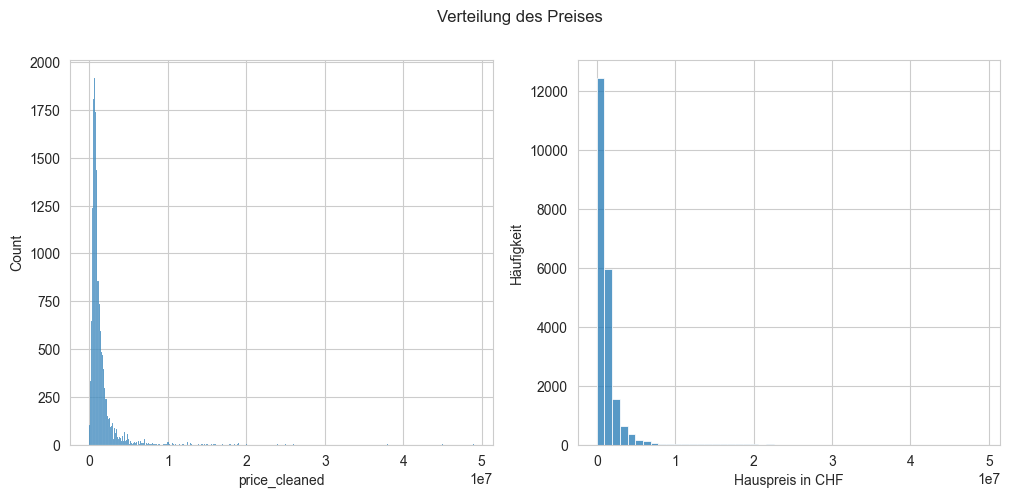

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df_clean, x="price_cleaned", bins=500, ax=ax[0])
plt.xlabel("Hauspreis in CHF")
plt.ylabel("Häufigkeit")
plt.suptitle("Verteilung des Preises")
sns.histplot(data=df_clean, x="price_cleaned", bins=50, ax=ax[1])
plt.xlabel("Hauspreis in CHF")
plt.ylabel("Häufigkeit")
plt.show()

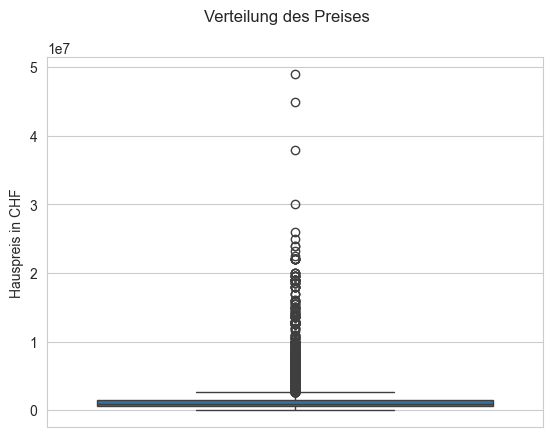

In [168]:
plt.figsize=(7, 7)
plt.suptitle("Verteilung des Preises")
sns.boxplot(data=df_clean, y="price_cleaned")
plt.ylabel("Hauspreis in CHF")
plt.show()

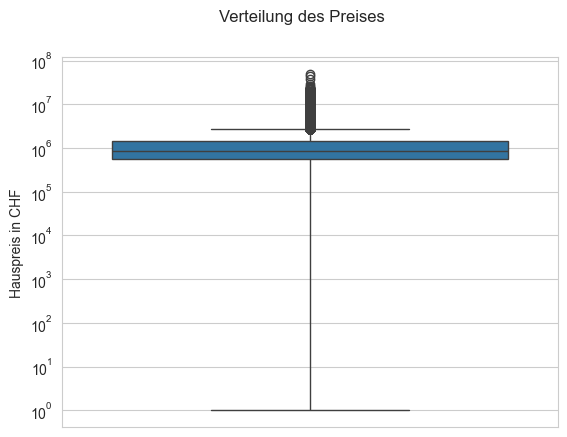

In [169]:
plt.figsize=(7, 7)
plt.suptitle("Verteilung des Preises")
sns.boxplot(data=df_clean, y="price_cleaned")
plt.ylabel("Hauspreis in CHF")
# Apply logarithmic scale to the y-axis
plt.yscale('log')

# Show the plot
plt.show()

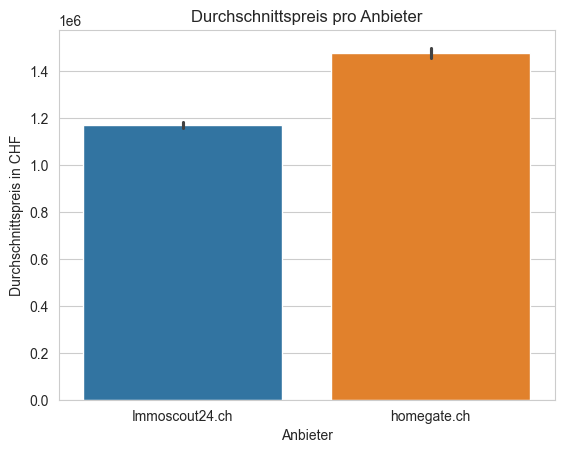

In [170]:
plt.figsize=(7, 7)
sns.barplot(data=df_clean, x="provider", hue="provider",y="price_cleaned",estimator="mean", errorbar="se")
plt.title("Durchschnittspreis pro Anbieter")
plt.xlabel("Anbieter")
plt.ylabel("Durchschnittspreis in CHF")
plt.show()

In [171]:
df_clean["type"].value_counts().sort_values()

type
Hobby room                           1
Granny flat                          1
single-room                          1
Cellar compartment                   1
secondary-suite                      1
Castle                               3
detached-secondary-suite             4
Rustic house                         4
attic-room                           6
Attic                                6
Furnished dwelling                   8
castle                               9
Terrace house                       15
Loft                                17
furnished-residential-property      17
loft                                26
studio                              27
Farm house                          62
stepped-house                       64
rustico                             65
Studio                              69
Terrace flat                        75
farmhouse                          110
Roof flat                          114
stepped-apartment                  140
Multi-family house  

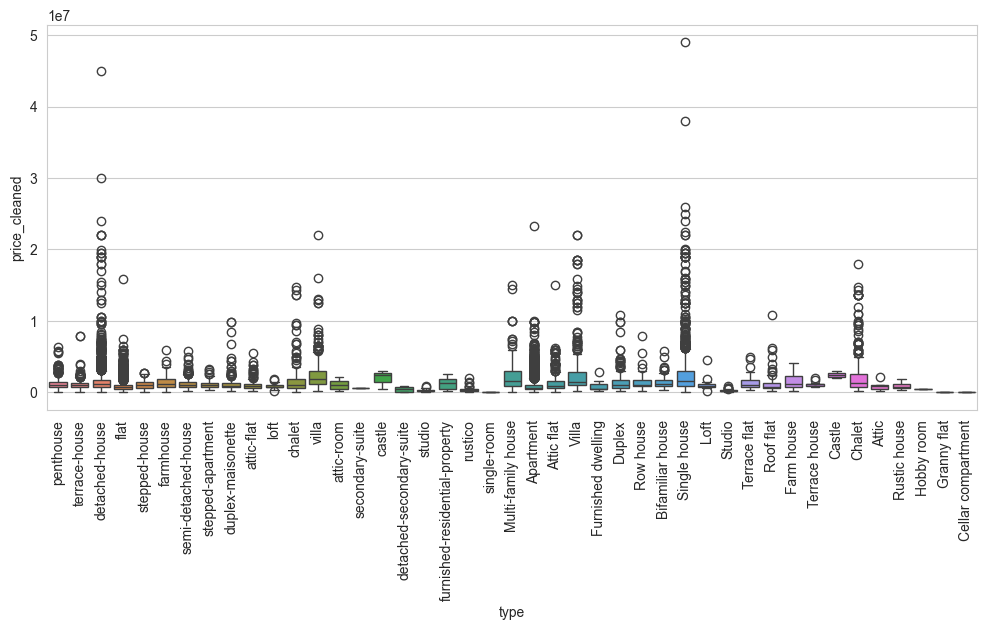

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.boxplot(data=df_clean, x="type", y="price_cleaned",hue="type", ax=ax)
plt.xticks(rotation=90)
plt.show()

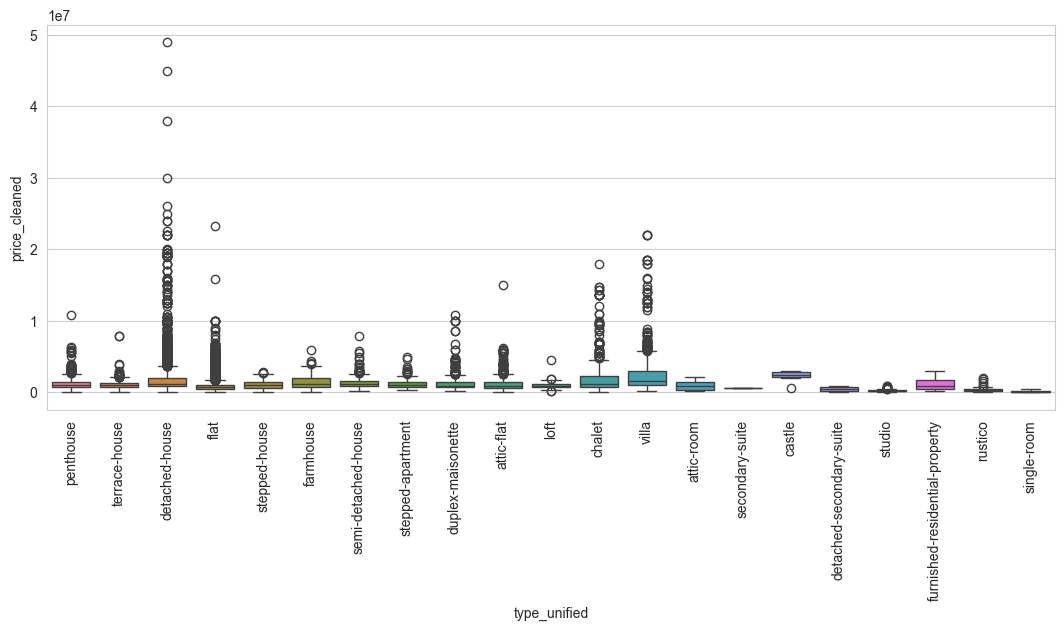

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
sns.boxplot(data=df_clean, x="type_unified", y="price_cleaned",hue="type_unified", ax=ax)
plt.xticks(rotation=90)
plt.show()

In [174]:
df_clean["type_unified"].value_counts().sort_values()


type_unified
secondary-suite                       1
single-room                           3
detached-secondary-suite              4
castle                               12
attic-room                           12
furnished-residential-property       25
loft                                 43
stepped-house                        64
rustico                              69
studio                               96
farmhouse                           172
stepped-apartment                   215
terrace-house                       538
penthouse                           665
attic-flat                          690
chalet                              697
duplex-maisonette                   713
semi-detached-house                 869
villa                              1255
detached-house                     5514
flat                              10824
Name: count, dtype: int64

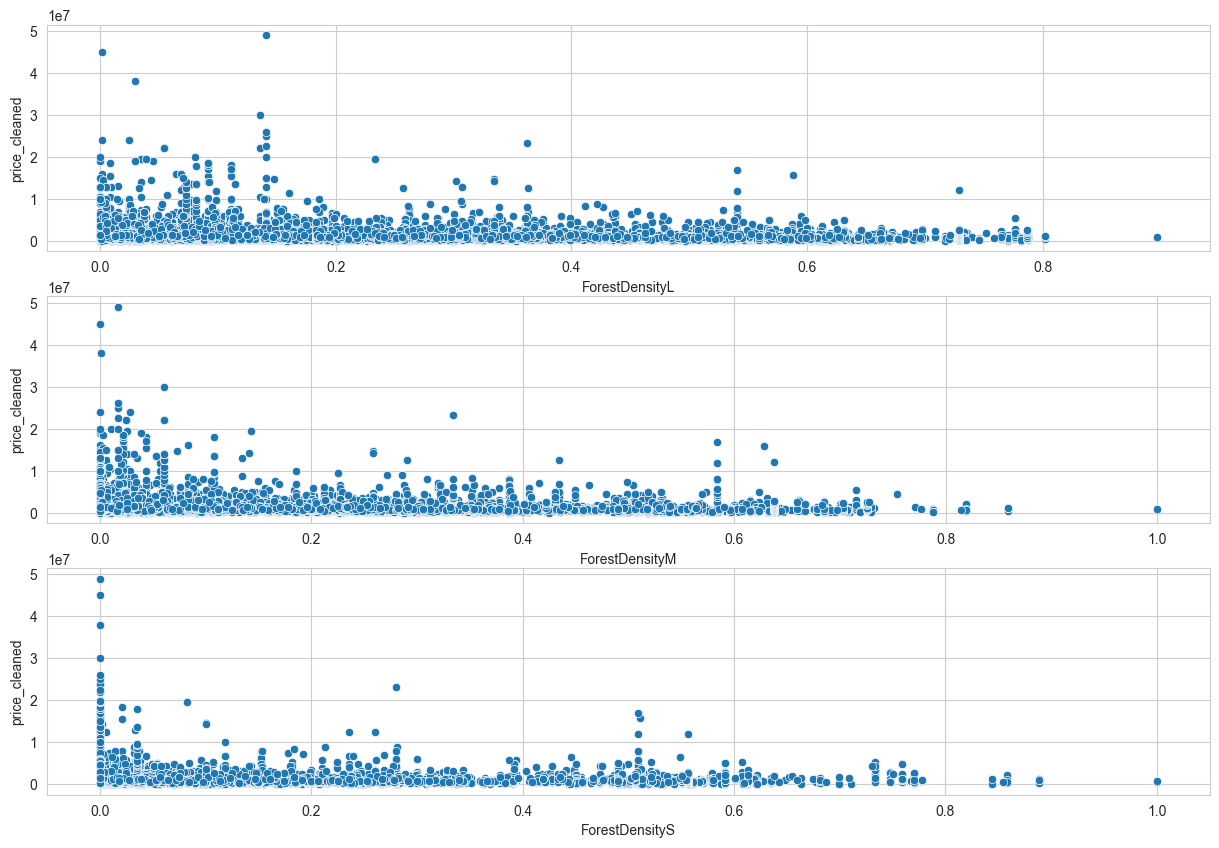

In [175]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.scatterplot(data=df_clean, x="ForestDensityL", y="price_cleaned", ax=ax[0])
sns.scatterplot(data=df_clean, x="ForestDensityM", y="price_cleaned", ax=ax[1])
sns.scatterplot(data=df_clean, x="ForestDensityS", y="price_cleaned", ax=ax[2])
plt.show()

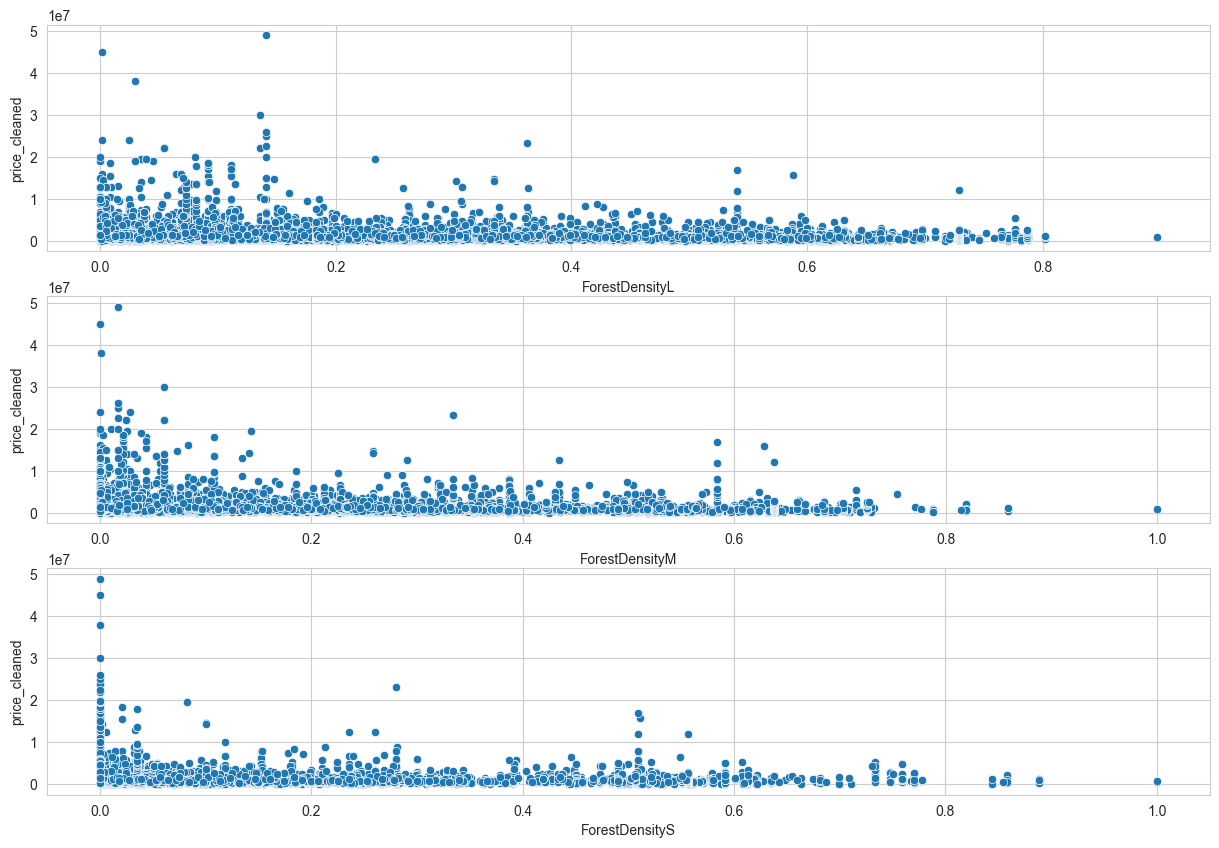

In [176]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.scatterplot(data=df_clean, x="ForestDensityL", y="price_cleaned", ax=ax[0])
sns.scatterplot(data=df_clean, x="ForestDensityM", y="price_cleaned", ax=ax[1])
sns.scatterplot(data=df_clean, x="ForestDensityS", y="price_cleaned", ax=ax[2])
plt.show()

In [202]:
prov = df_clean.copy()
prov["Floor_space_merged"] = prov["Floor_space_merged"].str.strip("m²")

In [203]:
prov = prov[~prov["Floor_space_merged"].isna()]

In [204]:
prov

,Availability,Floor,detail_responsive#surface_usable,Gross return,Floor_space_merged,details,lat,lon,ForestDensityL,ForestDensityM,...,type_unified,Plot_area_unified,provider,No. of rooms:,Number of apartments:,Room height:,Last refurbishment:,Year built:,features,Number of floors:
1,On request,NaN,NaN,NaN,242,"4.5 rooms, 156 m²,",47.419500,8.082700,0.511176,0.286451,...,terrace-house,222.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
3,On request,NaN,NaN,NaN,257,"4.5 rooms, 154 m²,",47.415643,8.085423,0.511176,0.286451,...,detached-house,370.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
5,On request,NaN,NaN,NaN,220,"5.5 rooms, 190 m²,",47.400935,8.012460,0.190581,0.162838,...,detached-house,1063.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
12,On request,NaN,NaN,NaN,132,"5 rooms, 152 m²,",47.386717,8.039244,0.156964,0.074427,...,detached-house,839.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
21,On request,NaN,NaN,NaN,140,"4.5 rooms, 236 m²,",47.396866,8.013374,0.140373,0.140085,...,stepped-house,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13284,On request,NaN,NaN,NaN,172,"4.5 rooms, 129 m²,",47.415051,8.853885,0.276932,0.061484,...,semi-detached-house,245.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
13293,On request,NaN,NaN,NaN,228,"5.5 rooms, 153 m²,",47.415051,8.853885,0.276932,0.061484,...,semi-detached-house,233.0,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
13307,On request,7. floor,NaN,NaN,79,"3.5 rooms, 72 m²,",47.388185,8.681290,0.029197,0.000000,...,flat,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN
13317,Immediately,2. floor,NaN,NaN,136,"4.5 rooms, 118 m²,",47.389862,8.690503,0.120618,0.054523,...,duplex-maisonette,NaN,Immoscout24.ch,5.0,NaN,NaN,NaN,NaN,NaN,NaN


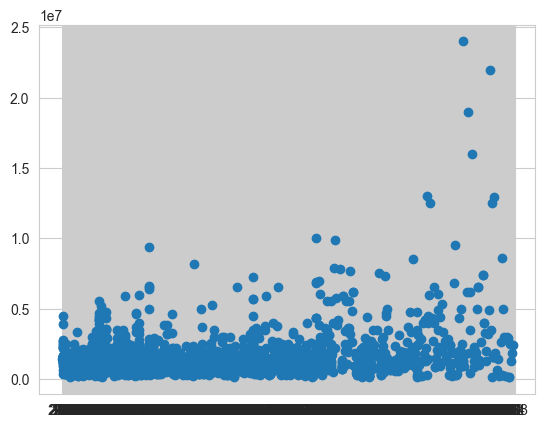

In [205]:
plt.scatter(prov["Floor_space_merged"],prov["price_cleaned"])